# Approximating data using deep learning

Note that for this approach we based ourselves on the Standford lecture notes on convolutional neural networks for visual recognition.

This lecture is open source and can be found on http://cs231n.github.io/ 

In [23]:
# Clean up the memory
%reset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%load_ext autoreload
%autoreload 2

import gc

import crowd

import numpy as np
import math

import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
DATA_FOLDER = "data/"
SESSION_FOLDER = "session/"

TRAIN_SET_PERC = 0.75

In [5]:
def rmse(pred, real, loop = True):
    '''
    Computes RMSE between predictions and real values
    :param : float[]
    :param : float[]
    :return : float
    '''
    if len(pred) != len(real):
        print("RMSE Error : Predictions and real values arrays do not have the same length, aborting.")
        return None
    
    if loop:
        mse = 0
        for i in range(len(pred)):
            mse += (pred[i] - real[i])**2
        return math.sqrt(mse/len(pred))
    else:
        # The creation of the array may produce memory error
        err = pred - real
        mse = err.T @ err
        return math.sqrt(2 * mse / len(pred))
    
    
def basic_error(pred, real):
    '''
    Compute basic error. Used to notify bias.
    :param : float[]
    :param : float[]
    :return : float
    '''
    err = 0
    for i in range(len(pred)):
        err += (pred[i][0][0] - real[i])
    return err
    
    
def build_poly(X, degree):
    poly = np.ones((len(X), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(X, deg)]
    return poly[:, 1:]

def garbage_collection():
    '''
    Calls garbage collection to clean unused memory
    '''
    gc.collect()

In [6]:
def plot_history(history):
    '''
    Plots the history of the training error
    Usefull 
    '''
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0, 5])

## Preparing the data



In [6]:
# Use non normalized feature matrix
# For now best results are given with this one
#X = np.load(DATA_FOLDER + "feature_mat_radial_compression.npy")

# Use normalized feature matrix
################################################################################################
# Careful                                                                                      #
# Normally, normalisation should be done one each train/val/test matrices. It is not done here #
################################################################################################
X = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")

In [11]:
# Prepare train and test set

train_set_size = int(len(X) * TRAIN_SET_PERC)
X_train = X[: train_set_size]
X_test = X[train_set_size:]
y_train = y[: train_set_size]
y_test = y[train_set_size :]

In [12]:
print("X: " + str(X.shape))
print("y: " + str(y.shape))

X: (30049, 15961)
y: (30049,)


# Single neural network model approach

First we will do a single model approach, the goal is to see quickly how we can build a model using neural networks and how well it does. 

In [14]:
# Clean up as much memory as possible before starting
garbage_collection()

# Prepare model 
model = tf.keras.Sequential([
    # Number of layers and neurons doesn't really matter, we need as much as possible.
    # We well take care of overfitting with regularizers.
    # We chose relu activation (relative usual choice when working on regression)
    # We add L2 regularizers on hidden layers to avoid overfitting the data. Threshold should be tuned.
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    # Last layer represent the electromagnetic shielding, our prediction
    layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])

In [15]:
# We train the model on our data
# Number of epochs the network should run through
EPOCHS = 200
# Size of the batch for optimization
BATCH_SIZE = 32
# Set up validation split
VALIDATION_SPLIT = 0.1
# The patience parameter is the amount of epochs to check for improvement
# This will avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
model.summary()

Train on 24339 samples, validate on 2705 samples
Epoch 1/200
24339/24339 [==============================] - 33s 1ms/step - loss: 16.2263 - mean_absolute_error: 2.3938 - val_loss: 6.2262 - val_mean_absolute_error: 1.8358
Epoch 2/200
24339/24339 [==============================] - 33s 1ms/step - loss: 3.2662 - mean_absolute_error: 1.3039 - val_loss: 4.0006 - val_mean_absolute_error: 1.4015
Epoch 3/200
24339/24339 [==============================] - 31s 1ms/step - loss: 1.8035 - mean_absolute_error: 0.9428 - val_loss: 4.2133 - val_mean_absolute_error: 1.4561
Epoch 4/200
24339/24339 [==============================] - 31s 1ms/step - loss: 1.7472 - mean_absolute_error: 0.9308 - val_loss: 3.5445 - val_mean_absolute_error: 1.3147
Epoch 5/200
24339/24339 [==============================] - 31s 1ms/step - loss: 1.4083 - mean_absolute_error: 0.8200 - val_loss: 3.1718 - val_mean_absolute_error: 1.2550
Epoch 6/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.9822 - mean_absolu

Epoch 49/200
24339/24339 [==============================] - 33s 1ms/step - loss: 0.2332 - mean_absolute_error: 0.2662 - val_loss: 0.6181 - val_mean_absolute_error: 0.5156
Epoch 50/200
24339/24339 [==============================] - 32s 1ms/step - loss: 0.2462 - mean_absolute_error: 0.2666 - val_loss: 0.5834 - val_mean_absolute_error: 0.4958
Epoch 51/200
24339/24339 [==============================] - 34s 1ms/step - loss: 0.2626 - mean_absolute_error: 0.2700 - val_loss: 0.6383 - val_mean_absolute_error: 0.5298
Epoch 52/200
24339/24339 [==============================] - 35s 1ms/step - loss: 0.2387 - mean_absolute_error: 0.2609 - val_loss: 0.6260 - val_mean_absolute_error: 0.5193
Epoch 53/200
24339/24339 [==============================] - 33s 1ms/step - loss: 0.2534 - mean_absolute_error: 0.2679 - val_loss: 0.7373 - val_mean_absolute_error: 0.5672
Epoch 54/200
24339/24339 [==============================] - 30s 1ms/step - loss: 0.2392 - mean_absolute_error: 0.2541 - val_loss: 0.6180 - val_me

Epoch 97/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1789 - mean_absolute_error: 0.2405 - val_loss: 0.6396 - val_mean_absolute_error: 0.5494
Epoch 98/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1754 - mean_absolute_error: 0.2384 - val_loss: 0.5826 - val_mean_absolute_error: 0.5109
Epoch 99/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1846 - mean_absolute_error: 0.2464 - val_loss: 0.6068 - val_mean_absolute_error: 0.5251
Epoch 100/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1732 - mean_absolute_error: 0.2346 - val_loss: 0.5752 - val_mean_absolute_error: 0.4983
Epoch 101/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1945 - mean_absolute_error: 0.2554 - val_loss: 0.5877 - val_mean_absolute_error: 0.5083
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dens

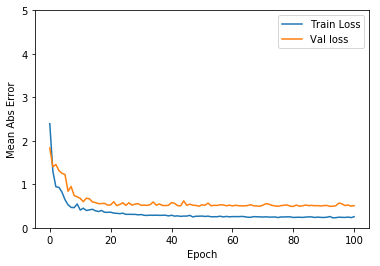

In [16]:
plot_history(history)

In [17]:
result = model.predict(X_test, batch_size=32)
rmse(result, y_test)

0.6604633181447641

## Results

For the following model :
    - 4 hidden layers of 64 neurons - relu activation.
    - A result layer of 1 neuron - relu activation.
    - Early stopping callback
    - Test split of 0.2
    - Using AdamOptimizer gives best results.
    - No cross validation.
    
Network size :
- $4*64 + 1 = 257$ neurons (biases)
- $30049*64 + 64*64 + 64*64 + 64 = 1931392$ weights
- Total of $1931649$ learnable parameters (almost 2 millions)

With the above, we reached a RMSE of 0.5. But this is without separating the data into train and test set. This can lead to overfitting. Now we need to ensure that we are not overfitting.

For this we will test 2 solutions :

### Change our implementation to add regulizer that will avoid this overfitting

### Cross validation over multiple models

# Multi neural network approach

In [7]:
X_red = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized_red.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")
X_red.shape

(30049, 3004)

In [8]:
train_set_size = int(len(X_red) * TRAIN_SET_PERC)

# Select random rows of the matrix for train / test set
# Random seed for reproducibility 
np.random.seed(100)
train_idx = np.random.choice(len(X_red), size=train_set_size, replace = False)
test_idx = [i for i in range(len(X_red)) if i not in train_idx]
X_train_red = X_red[train_idx, :]
X_test_red = X_red[test_idx, :]
y_train = y[train_idx]
y_test = y[test_idx]

In [9]:
print("X_red: " + str(X_red.shape))
print("y: " + str(y.shape))

X_red: (30049, 3004)
y: (30049,)


In [12]:
crowd01 = crowd.Crowd(X_train_red, y_train, "DNN_Crowd")
crowd01.restore()

No directory with name session/DNN_Crowd_8_128_relu_0.01_0.001_mse


In [16]:
crowd01.train_new_entities(8)

Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20160/20282 [============================>.] - ETA: 0s - loss: 30.5333 - mean_absolute_error: 2.9565
Epoch 00001: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/8
20282/20282 [==============================] - 6s 314us/step - loss: 30.4944 - mean_absolute_error: 2.9535 - val_loss: 17.4383 - val_mean_absolute_error: 2.5045
Epoch 2/200
20096/20282 [============================>.] - ETA: 0s - loss: 12.0771 - mean_absolute_error: 1.5979
Epoch 00002: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/8
20282/20282 [==============================] - 5s 223us/step - loss: 12.0425 - mean_absolute_error: 1.5925 - val_loss: 9.3693 - val_mean_absolute_error: 1.2459
Epoch 3/200
20000/20282 [============================>.] - ETA: 0s - loss: 7.3729 - mean_absolute_error: 0.8543
Epoch 00003: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/8
20282/20282 [==============================] - 4s 217us/step - loss

Epoch 25/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.7345 - mean_absolute_error: 0.4307
Epoch 00025: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/8
20282/20282 [==============================] - 4s 195us/step - loss: 0.7360 - mean_absolute_error: 0.4313 - val_loss: 1.0370 - val_mean_absolute_error: 0.5749
Epoch 26/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.7434 - mean_absolute_error: 0.4241
Epoch 00026: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/8
20282/20282 [==============================] - 4s 195us/step - loss: 0.7434 - mean_absolute_error: 0.4241 - val_loss: 0.8503 - val_mean_absolute_error: 0.4718
Epoch 27/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.7319 - mean_absolute_error: 0.4322
Epoch 00027: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/8
20282/20282 [==============================] - 4s 194us/step - loss: 0.7316 - mean_absolute_error: 0.4320 - val_loss: 

Epoch 49/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5678 - mean_absolute_error: 0.4034
Epoch 00049: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/8
20282/20282 [==============================] - 4s 197us/step - loss: 0.5676 - mean_absolute_error: 0.4033 - val_loss: 0.6796 - val_mean_absolute_error: 0.4398
Epoch 50/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5679 - mean_absolute_error: 0.3977
Epoch 00050: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/8
20282/20282 [==============================] - 4s 193us/step - loss: 0.5681 - mean_absolute_error: 0.3980 - val_loss: 0.6230 - val_mean_absolute_error: 0.4270
Epoch 51/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5502 - mean_absolute_error: 0.3939
Epoch 00051: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/8
20282/20282 [==============================] - 4s 197us/step - loss: 0.5512 - mean_absolute_error: 0.3944 - val_loss: 

Epoch 73/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5533 - mean_absolute_error: 0.3985
Epoch 00073: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/8
20282/20282 [==============================] - 4s 195us/step - loss: 0.5534 - mean_absolute_error: 0.3986 - val_loss: 0.6348 - val_mean_absolute_error: 0.4308
Epoch 74/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5147 - mean_absolute_error: 0.3759
Epoch 00074: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/8
20282/20282 [==============================] - 4s 193us/step - loss: 0.5145 - mean_absolute_error: 0.3759 - val_loss: 0.6006 - val_mean_absolute_error: 0.4209
Epoch 75/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5079 - mean_absolute_error: 0.3773
Epoch 00075: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/8
20282/20282 [==============================] - 4s 193us/step - loss: 0.5085 - mean_absolute_error: 0.3778 - val_loss: 

Epoch 97/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5014 - mean_absolute_error: 0.3747
Epoch 00097: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/8
20282/20282 [==============================] - 4s 195us/step - loss: 0.5022 - mean_absolute_error: 0.3751 - val_loss: 0.6288 - val_mean_absolute_error: 0.4312
Epoch 98/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5269 - mean_absolute_error: 0.3902
Epoch 00098: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/8
20282/20282 [==============================] - 4s 194us/step - loss: 0.5268 - mean_absolute_error: 0.3901 - val_loss: 0.6086 - val_mean_absolute_error: 0.4307
Epoch 99/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5073 - mean_absolute_error: 0.3775
Epoch 00099: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/8
20282/20282 [==============================] - 4s 197us/step - loss: 0.5072 - mean_absolute_error: 0.3775 - val_loss: 

Epoch 121/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5089 - mean_absolute_error: 0.3789
Epoch 00121: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/8
20282/20282 [==============================] - 4s 198us/step - loss: 0.5089 - mean_absolute_error: 0.3791 - val_loss: 0.6240 - val_mean_absolute_error: 0.4399
Epoch 122/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.4954 - mean_absolute_error: 0.3705
Epoch 00122: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/8
20282/20282 [==============================] - 4s 194us/step - loss: 0.4964 - mean_absolute_error: 0.3716 - val_loss: 0.7466 - val_mean_absolute_error: 0.5354
Epoch 123/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5029 - mean_absolute_error: 0.3784
Epoch 00123: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/8
20282/20282 [==============================] - 4s 196us/step - loss: 0.5032 - mean_absolute_error: 0.3788 - val_los

Epoch 20/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.8918 - mean_absolute_error: 0.4625
Epoch 00020: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/9
20282/20282 [==============================] - 4s 202us/step - loss: 0.8920 - mean_absolute_error: 0.4626 - val_loss: 0.9949 - val_mean_absolute_error: 0.5008
Epoch 21/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.8422 - mean_absolute_error: 0.4481
Epoch 00021: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/9
20282/20282 [==============================] - 4s 204us/step - loss: 0.8422 - mean_absolute_error: 0.4480 - val_loss: 0.8896 - val_mean_absolute_error: 0.4564
Epoch 22/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.8117 - mean_absolute_error: 0.4394
Epoch 00022: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/9
20282/20282 [==============================] - 4s 205us/step - loss: 0.8122 - mean_absolute_error: 0.4396 - val_loss: 

Epoch 44/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5662 - mean_absolute_error: 0.4056
Epoch 00044: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/9
20282/20282 [==============================] - 4s 204us/step - loss: 0.5663 - mean_absolute_error: 0.4059 - val_loss: 0.7229 - val_mean_absolute_error: 0.4915
Epoch 45/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5514 - mean_absolute_error: 0.3932
Epoch 00045: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/9
20282/20282 [==============================] - 4s 204us/step - loss: 0.5517 - mean_absolute_error: 0.3933 - val_loss: 0.7170 - val_mean_absolute_error: 0.4824
Epoch 46/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5647 - mean_absolute_error: 0.4052
Epoch 00046: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/9
20282/20282 [==============================] - 4s 204us/step - loss: 0.5650 - mean_absolute_error: 0.4055 - val_loss: 

Epoch 68/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5338 - mean_absolute_error: 0.3952
Epoch 00068: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/9
20282/20282 [==============================] - 4s 201us/step - loss: 0.5342 - mean_absolute_error: 0.3955 - val_loss: 0.7581 - val_mean_absolute_error: 0.5252
Epoch 69/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.5216 - mean_absolute_error: 0.3848
Epoch 00069: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/9
20282/20282 [==============================] - 4s 201us/step - loss: 0.5214 - mean_absolute_error: 0.3848 - val_loss: 0.6438 - val_mean_absolute_error: 0.4686
Epoch 70/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5194 - mean_absolute_error: 0.3850
Epoch 00070: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/9
20282/20282 [==============================] - 4s 199us/step - loss: 0.5193 - mean_absolute_error: 0.3851 - val_loss: 

Epoch 92/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5167 - mean_absolute_error: 0.3910
Epoch 00092: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/9
20282/20282 [==============================] - 4s 217us/step - loss: 0.5169 - mean_absolute_error: 0.3909 - val_loss: 0.5909 - val_mean_absolute_error: 0.4167
Epoch 93/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5086 - mean_absolute_error: 0.3826
Epoch 00093: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/9
20282/20282 [==============================] - 4s 213us/step - loss: 0.5088 - mean_absolute_error: 0.3828 - val_loss: 0.6082 - val_mean_absolute_error: 0.4240
Epoch 94/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.4915 - mean_absolute_error: 0.3761
Epoch 00094: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/9
20282/20282 [==============================] - 4s 211us/step - loss: 0.4928 - mean_absolute_error: 0.3766 - val_loss: 

Epoch 4/200
20192/20282 [============================>.] - ETA: 0s - loss: 4.8158 - mean_absolute_error: 0.5074
Epoch 00004: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/10
20282/20282 [==============================] - 4s 207us/step - loss: 4.8136 - mean_absolute_error: 0.5074 - val_loss: 4.6076 - val_mean_absolute_error: 0.6509
Epoch 5/200
20064/20282 [============================>.] - ETA: 0s - loss: 3.9173 - mean_absolute_error: 0.5161
Epoch 00005: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/10
20282/20282 [==============================] - 4s 211us/step - loss: 3.9125 - mean_absolute_error: 0.5157 - val_loss: 3.8339 - val_mean_absolute_error: 0.6372
Epoch 6/200
20096/20282 [============================>.] - ETA: 0s - loss: 3.2217 - mean_absolute_error: 0.5190
Epoch 00006: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/10
20282/20282 [==============================] - 4s 209us/step - loss: 3.2175 - mean_absolute_error: 0.5186 - val_loss: 

Epoch 28/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.7159 - mean_absolute_error: 0.4245
Epoch 00028: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/10
20282/20282 [==============================] - 4s 207us/step - loss: 0.7153 - mean_absolute_error: 0.4243 - val_loss: 0.8442 - val_mean_absolute_error: 0.5143
Epoch 29/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.7031 - mean_absolute_error: 0.4272
Epoch 00029: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/10
20282/20282 [==============================] - 4s 207us/step - loss: 0.7054 - mean_absolute_error: 0.4288 - val_loss: 1.7064 - val_mean_absolute_error: 1.0008
Epoch 30/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6953 - mean_absolute_error: 0.4315
Epoch 00030: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/10
20282/20282 [==============================] - 4s 210us/step - loss: 0.6949 - mean_absolute_error: 0.4314 - val_los

Epoch 52/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.5686 - mean_absolute_error: 0.3981
Epoch 00052: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/10
20282/20282 [==============================] - 4s 209us/step - loss: 0.5687 - mean_absolute_error: 0.3982 - val_loss: 0.7249 - val_mean_absolute_error: 0.4864
Epoch 53/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5611 - mean_absolute_error: 0.4002
Epoch 00053: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/10
20282/20282 [==============================] - 4s 208us/step - loss: 0.5607 - mean_absolute_error: 0.3999 - val_loss: 0.6734 - val_mean_absolute_error: 0.4574
Epoch 54/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5432 - mean_absolute_error: 0.3923
Epoch 00054: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/10
20282/20282 [==============================] - 4s 207us/step - loss: 0.5438 - mean_absolute_error: 0.3928 - val_los

Epoch 76/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5360 - mean_absolute_error: 0.3979
Epoch 00076: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/10
20282/20282 [==============================] - 4s 207us/step - loss: 0.5364 - mean_absolute_error: 0.3979 - val_loss: 0.6371 - val_mean_absolute_error: 0.4381
Epoch 77/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5317 - mean_absolute_error: 0.3932
Epoch 00077: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/10
20282/20282 [==============================] - 4s 208us/step - loss: 0.5328 - mean_absolute_error: 0.3939 - val_loss: 0.6233 - val_mean_absolute_error: 0.4333
Epoch 78/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5322 - mean_absolute_error: 0.3922
Epoch 00078: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/10
20282/20282 [==============================] - 4s 206us/step - loss: 0.5325 - mean_absolute_error: 0.3926 - val_los

Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20256/20282 [============================>.] - ETA: 0s - loss: 30.6804 - mean_absolute_error: 2.9762
Epoch 00001: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/11
20282/20282 [==============================] - 7s 337us/step - loss: 30.6621 - mean_absolute_error: 2.9750 - val_loss: 14.0431 - val_mean_absolute_error: 1.8957
Epoch 2/200
20256/20282 [============================>.] - ETA: 0s - loss: 11.6620 - mean_absolute_error: 1.5352
Epoch 00002: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/11
20282/20282 [==============================] - 4s 217us/step - loss: 11.6587 - mean_absolute_error: 1.5349 - val_loss: 8.4707 - val_mean_absolute_error: 1.0381
Epoch 3/200
20032/20282 [============================>.] - ETA: 0s - loss: 7.0426 - mean_absolute_error: 0.8110
Epoch 00003: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/11
20282/20282 [==============================] - 4s 215us/step - l

Epoch 25/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.7684 - mean_absolute_error: 0.4294
Epoch 00025: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/11
20282/20282 [==============================] - 4s 217us/step - loss: 0.7675 - mean_absolute_error: 0.4288 - val_loss: 0.8354 - val_mean_absolute_error: 0.4735
Epoch 26/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.7432 - mean_absolute_error: 0.4290
Epoch 00026: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/11
20282/20282 [==============================] - 4s 219us/step - loss: 0.7436 - mean_absolute_error: 0.4292 - val_loss: 0.8699 - val_mean_absolute_error: 0.4643
Epoch 27/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.7788 - mean_absolute_error: 0.4419
Epoch 00027: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/11
20282/20282 [==============================] - 4s 215us/step - loss: 0.7804 - mean_absolute_error: 0.4429 - val_los

Epoch 49/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5490 - mean_absolute_error: 0.3966
Epoch 00049: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/11
20282/20282 [==============================] - 4s 217us/step - loss: 0.5488 - mean_absolute_error: 0.3966 - val_loss: 0.6281 - val_mean_absolute_error: 0.4222
Epoch 50/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.5299 - mean_absolute_error: 0.3851
Epoch 00050: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/11
20282/20282 [==============================] - 4s 216us/step - loss: 0.5297 - mean_absolute_error: 0.3850 - val_loss: 0.6483 - val_mean_absolute_error: 0.4610
Epoch 51/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5294 - mean_absolute_error: 0.3881
Epoch 00051: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/11
20282/20282 [==============================] - 4s 221us/step - loss: 0.5298 - mean_absolute_error: 0.3884 - val_los

Epoch 73/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5037 - mean_absolute_error: 0.3819
Epoch 00073: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/11
20282/20282 [==============================] - 4s 220us/step - loss: 0.5039 - mean_absolute_error: 0.3820 - val_loss: 0.6091 - val_mean_absolute_error: 0.4364
Epoch 74/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5012 - mean_absolute_error: 0.3824
Epoch 00074: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/11
20282/20282 [==============================] - 4s 219us/step - loss: 0.5008 - mean_absolute_error: 0.3821 - val_loss: 0.6245 - val_mean_absolute_error: 0.4434
Epoch 75/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5113 - mean_absolute_error: 0.3882
Epoch 00075: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/11
20282/20282 [==============================] - 4s 218us/step - loss: 0.5114 - mean_absolute_error: 0.3882 - val_los

Epoch 15/200
20032/20282 [============================>.] - ETA: 0s - loss: 1.1263 - mean_absolute_error: 0.5053
Epoch 00015: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/12
20282/20282 [==============================] - 4s 218us/step - loss: 1.1275 - mean_absolute_error: 0.5059 - val_loss: 1.3808 - val_mean_absolute_error: 0.6494
Epoch 16/200
20224/20282 [============================>.] - ETA: 0s - loss: 1.0414 - mean_absolute_error: 0.4851
Epoch 00016: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/12
20282/20282 [==============================] - 4s 218us/step - loss: 1.0425 - mean_absolute_error: 0.4859 - val_loss: 1.1567 - val_mean_absolute_error: 0.5458
Epoch 17/200
20256/20282 [============================>.] - ETA: 0s - loss: 1.0403 - mean_absolute_error: 0.4904
Epoch 00017: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/12
20282/20282 [==============================] - 4s 216us/step - loss: 1.0406 - mean_absolute_error: 0.4905 - val_los

Epoch 39/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5670 - mean_absolute_error: 0.3969
Epoch 00039: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/12
20282/20282 [==============================] - 4s 220us/step - loss: 0.5668 - mean_absolute_error: 0.3968 - val_loss: 0.6714 - val_mean_absolute_error: 0.4481
Epoch 40/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5740 - mean_absolute_error: 0.4063
Epoch 00040: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/12
20282/20282 [==============================] - 4s 218us/step - loss: 0.5742 - mean_absolute_error: 0.4064 - val_loss: 0.6361 - val_mean_absolute_error: 0.4311
Epoch 41/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5843 - mean_absolute_error: 0.4180
Epoch 00041: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/12
20282/20282 [==============================] - 4s 220us/step - loss: 0.5845 - mean_absolute_error: 0.4175 - val_los

Epoch 63/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5136 - mean_absolute_error: 0.3831
Epoch 00063: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/12
20282/20282 [==============================] - 4s 218us/step - loss: 0.5138 - mean_absolute_error: 0.3832 - val_loss: 0.6431 - val_mean_absolute_error: 0.4504
Epoch 64/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5214 - mean_absolute_error: 0.3910
Epoch 00064: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/12
20282/20282 [==============================] - 4s 219us/step - loss: 0.5215 - mean_absolute_error: 0.3909 - val_loss: 0.6661 - val_mean_absolute_error: 0.4594
Epoch 65/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5424 - mean_absolute_error: 0.4037
Epoch 00065: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/12
20282/20282 [==============================] - 4s 219us/step - loss: 0.5429 - mean_absolute_error: 0.4040 - val_los

Epoch 87/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5099 - mean_absolute_error: 0.3857
Epoch 00087: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/12
20282/20282 [==============================] - 4s 217us/step - loss: 0.5101 - mean_absolute_error: 0.3858 - val_loss: 0.6200 - val_mean_absolute_error: 0.4410
Epoch 88/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.5022 - mean_absolute_error: 0.3776
Epoch 00088: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/12
20282/20282 [==============================] - 4s 220us/step - loss: 0.5022 - mean_absolute_error: 0.3777 - val_loss: 0.6253 - val_mean_absolute_error: 0.4387
Epoch 89/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5085 - mean_absolute_error: 0.3806
Epoch 00089: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/12
20282/20282 [==============================] - 4s 218us/step - loss: 0.5087 - mean_absolute_error: 0.3808 - val_los

Epoch 21/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.8636 - mean_absolute_error: 0.4465
Epoch 00021: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/13
20282/20282 [==============================] - 4s 221us/step - loss: 0.8632 - mean_absolute_error: 0.4463 - val_loss: 1.0300 - val_mean_absolute_error: 0.5324
Epoch 22/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.8777 - mean_absolute_error: 0.4669
Epoch 00022: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/13
20282/20282 [==============================] - 5s 224us/step - loss: 0.8775 - mean_absolute_error: 0.4668 - val_loss: 1.1386 - val_mean_absolute_error: 0.5982
Epoch 23/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.8427 - mean_absolute_error: 0.4551
Epoch 00023: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/13
20282/20282 [==============================] - 4s 221us/step - loss: 0.8435 - mean_absolute_error: 0.4556 - val_los

Epoch 45/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5944 - mean_absolute_error: 0.4134
Epoch 00045: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/13
20282/20282 [==============================] - 4s 221us/step - loss: 0.5946 - mean_absolute_error: 0.4136 - val_loss: 0.7250 - val_mean_absolute_error: 0.4661
Epoch 46/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.5817 - mean_absolute_error: 0.4012
Epoch 00046: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/13
20282/20282 [==============================] - 4s 221us/step - loss: 0.5821 - mean_absolute_error: 0.4014 - val_loss: 0.7761 - val_mean_absolute_error: 0.5199
Epoch 47/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5549 - mean_absolute_error: 0.3900
Epoch 00047: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/13
20282/20282 [==============================] - 5s 225us/step - loss: 0.5549 - mean_absolute_error: 0.3901 - val_los

Epoch 69/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5485 - mean_absolute_error: 0.3960
Epoch 00069: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/13
20282/20282 [==============================] - 5s 222us/step - loss: 0.5484 - mean_absolute_error: 0.3960 - val_loss: 0.7055 - val_mean_absolute_error: 0.4759
Epoch 70/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5327 - mean_absolute_error: 0.3873
Epoch 00070: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/13
20282/20282 [==============================] - 5s 232us/step - loss: 0.5326 - mean_absolute_error: 0.3872 - val_loss: 0.6168 - val_mean_absolute_error: 0.4266
Epoch 71/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5329 - mean_absolute_error: 0.3949
Epoch 00071: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/13
20282/20282 [==============================] - 5s 224us/step - loss: 0.5331 - mean_absolute_error: 0.3951 - val_los

Epoch 12/200
20128/20282 [============================>.] - ETA: 0s - loss: 1.2766 - mean_absolute_error: 0.4961
Epoch 00012: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/14
20282/20282 [==============================] - 5s 254us/step - loss: 1.2775 - mean_absolute_error: 0.4968 - val_loss: 1.3389 - val_mean_absolute_error: 0.5337
Epoch 13/200
20256/20282 [============================>.] - ETA: 0s - loss: 1.2406 - mean_absolute_error: 0.5267
Epoch 00013: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/14
20282/20282 [==============================] - 5s 247us/step - loss: 1.2405 - mean_absolute_error: 0.5266 - val_loss: 1.2938 - val_mean_absolute_error: 0.5750
Epoch 14/200
20160/20282 [============================>.] - ETA: 0s - loss: 1.1567 - mean_absolute_error: 0.5100
Epoch 00014: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/14
20282/20282 [==============================] - 5s 258us/step - loss: 1.1572 - mean_absolute_error: 0.5104 - val_los

Epoch 36/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.6100 - mean_absolute_error: 0.4016
Epoch 00036: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/14
20282/20282 [==============================] - 5s 267us/step - loss: 0.6105 - mean_absolute_error: 0.4018 - val_loss: 0.7091 - val_mean_absolute_error: 0.4264
Epoch 37/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.6066 - mean_absolute_error: 0.4098
Epoch 00037: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/14
20282/20282 [==============================] - 6s 274us/step - loss: 0.6068 - mean_absolute_error: 0.4102 - val_loss: 0.8222 - val_mean_absolute_error: 0.5490
Epoch 38/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6041 - mean_absolute_error: 0.4132
Epoch 00038: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/14
20282/20282 [==============================] - 6s 289us/step - loss: 0.6045 - mean_absolute_error: 0.4134 - val_los

Epoch 60/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5516 - mean_absolute_error: 0.3952
Epoch 00060: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/14
20282/20282 [==============================] - 5s 248us/step - loss: 0.5522 - mean_absolute_error: 0.3954 - val_loss: 0.6638 - val_mean_absolute_error: 0.4394
Epoch 61/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5624 - mean_absolute_error: 0.3920
Epoch 00061: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/14
20282/20282 [==============================] - 5s 245us/step - loss: 0.5622 - mean_absolute_error: 0.3920 - val_loss: 0.6407 - val_mean_absolute_error: 0.4422
Epoch 62/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5566 - mean_absolute_error: 0.4013
Epoch 00062: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/14
20282/20282 [==============================] - 5s 250us/step - loss: 0.5565 - mean_absolute_error: 0.4013 - val_los

Epoch 84/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5234 - mean_absolute_error: 0.3835
Epoch 00084: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/14
20282/20282 [==============================] - 5s 249us/step - loss: 0.5235 - mean_absolute_error: 0.3836 - val_loss: 0.6238 - val_mean_absolute_error: 0.4238
Epoch 85/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.5150 - mean_absolute_error: 0.3810
Epoch 00085: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/14
20282/20282 [==============================] - 5s 248us/step - loss: 0.5150 - mean_absolute_error: 0.3811 - val_loss: 0.6174 - val_mean_absolute_error: 0.4278
Epoch 86/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.5382 - mean_absolute_error: 0.3908
Epoch 00086: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/14
20282/20282 [==============================] - 5s 249us/step - loss: 0.5384 - mean_absolute_error: 0.3911 - val_los

Epoch 108/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.5055 - mean_absolute_error: 0.3798
Epoch 00108: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/14
20282/20282 [==============================] - 5s 248us/step - loss: 0.5055 - mean_absolute_error: 0.3799 - val_loss: 0.6268 - val_mean_absolute_error: 0.4375
Epoch 109/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5024 - mean_absolute_error: 0.3776
Epoch 00109: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/14
20282/20282 [==============================] - 5s 249us/step - loss: 0.5036 - mean_absolute_error: 0.3782 - val_loss: 0.6314 - val_mean_absolute_error: 0.4457
Epoch 110/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.5111 - mean_absolute_error: 0.3768
Epoch 00110: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/14
20282/20282 [==============================] - 5s 248us/step - loss: 0.5111 - mean_absolute_error: 0.3768 - val_

Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20256/20282 [============================>.] - ETA: 0s - loss: 41.9507 - mean_absolute_error: 3.4798
Epoch 00001: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/15
20282/20282 [==============================] - 9s 439us/step - loss: 41.9134 - mean_absolute_error: 3.4778 - val_loss: 13.0249 - val_mean_absolute_error: 1.9389
Epoch 2/200
20224/20282 [============================>.] - ETA: 0s - loss: 10.5294 - mean_absolute_error: 1.5225
Epoch 00002: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/15
20282/20282 [==============================] - 5s 253us/step - loss: 10.5210 - mean_absolute_error: 1.5216 - val_loss: 8.1355 - val_mean_absolute_error: 1.2309
Epoch 3/200
20256/20282 [============================>.] - ETA: 0s - loss: 6.0986 - mean_absolute_error: 0.7491
Epoch 00003: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/15
20282/20282 [==============================] - 5s 251us/step - l

Epoch 25/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.8700 - mean_absolute_error: 0.4485
Epoch 00025: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/15
20282/20282 [==============================] - 5s 251us/step - loss: 0.8695 - mean_absolute_error: 0.4484 - val_loss: 0.9413 - val_mean_absolute_error: 0.4911
Epoch 26/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.7758 - mean_absolute_error: 0.4269
Epoch 00026: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/15
20282/20282 [==============================] - 5s 254us/step - loss: 0.7774 - mean_absolute_error: 0.4274 - val_loss: 0.9810 - val_mean_absolute_error: 0.4975
Epoch 27/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.7354 - mean_absolute_error: 0.4174
Epoch 00027: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/15
20282/20282 [==============================] - 5s 251us/step - loss: 0.7354 - mean_absolute_error: 0.4173 - val_los

Epoch 49/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5832 - mean_absolute_error: 0.4077
Epoch 00049: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/15
20282/20282 [==============================] - 5s 253us/step - loss: 0.5841 - mean_absolute_error: 0.4080 - val_loss: 0.7776 - val_mean_absolute_error: 0.5020
Epoch 50/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5842 - mean_absolute_error: 0.4030
Epoch 00050: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/15
20282/20282 [==============================] - 5s 255us/step - loss: 0.5840 - mean_absolute_error: 0.4030 - val_loss: 0.6574 - val_mean_absolute_error: 0.4325
Epoch 51/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5554 - mean_absolute_error: 0.3923
Epoch 00051: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/15
20282/20282 [==============================] - 5s 256us/step - loss: 0.5551 - mean_absolute_error: 0.3922 - val_los

Epoch 73/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5518 - mean_absolute_error: 0.3922
Epoch 00073: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/15
20282/20282 [==============================] - 5s 255us/step - loss: 0.5523 - mean_absolute_error: 0.3927 - val_loss: 0.6890 - val_mean_absolute_error: 0.4777
Epoch 74/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.5116 - mean_absolute_error: 0.3755
Epoch 00074: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/15
20282/20282 [==============================] - 5s 253us/step - loss: 0.5117 - mean_absolute_error: 0.3757 - val_loss: 0.6092 - val_mean_absolute_error: 0.4306
Epoch 75/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5288 - mean_absolute_error: 0.3925
Epoch 00075: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/15
20282/20282 [==============================] - 5s 256us/step - loss: 0.5290 - mean_absolute_error: 0.3924 - val_los

Epoch 97/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5010 - mean_absolute_error: 0.3800
Epoch 00097: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/15
20282/20282 [==============================] - 5s 256us/step - loss: 0.5009 - mean_absolute_error: 0.3799 - val_loss: 0.6397 - val_mean_absolute_error: 0.4496
Epoch 98/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5000 - mean_absolute_error: 0.3801
Epoch 00098: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/15
20282/20282 [==============================] - 5s 254us/step - loss: 0.5009 - mean_absolute_error: 0.3807 - val_loss: 0.5877 - val_mean_absolute_error: 0.4239
Epoch 99/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.4942 - mean_absolute_error: 0.3743
Epoch 00099: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/15
20282/20282 [==============================] - 5s 252us/step - loss: 0.4941 - mean_absolute_error: 0.3743 - val_los

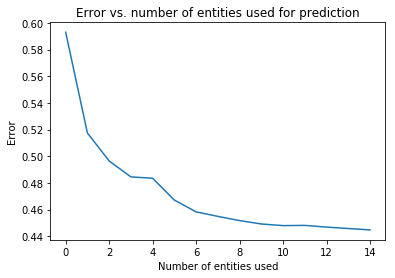

In [17]:
crowd01.plot_crowd_error(X_test_red, y_test, rmse)

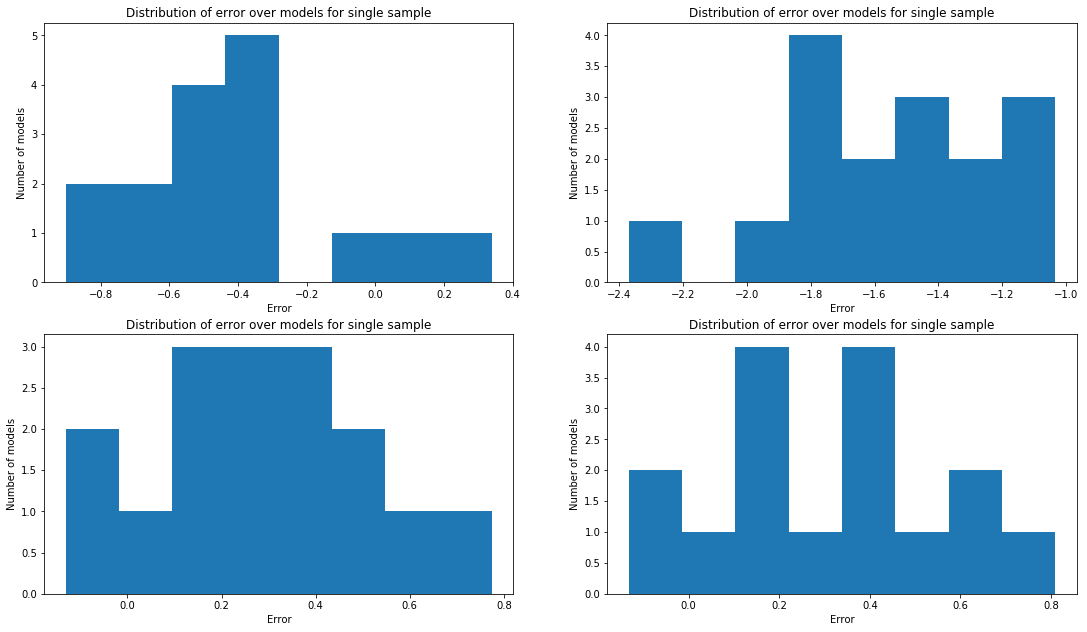

In [19]:
nb_bins = 8

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.subplot(221)
crowd01.plot_error_dist_on_sample(X_test_red[0], y_test[0], basic_error, show = False, bins = nb_bins)
plt.subplot(222)
crowd01.plot_error_dist_on_sample(X_test_red[1], y_test[1], basic_error, show = False, bins = nb_bins)
plt.subplot(223)
crowd01.plot_error_dist_on_sample(X_test_red[2], y_test[2], basic_error, show = False, bins = nb_bins)
plt.subplot(224)
crowd01.plot_error_dist_on_sample(X_test_red[3], y_test[3], basic_error, show = False, bins = nb_bins)
plt.show()

In [20]:
rmse(crowd01.predict(X_test_red), y_test)

0.4442079632254848

## Results
The results are good, however we remark a bias which has to be corrected using other networks in the crowd (of other type maybe).

# Trying Dropout layers
Dropout layers have been reported in the litterature to bring good results to avoid overfitting in combination with L2 regularizers http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf (Srivastava et al.). It will train the model while keeping only a neuron active with probability p.

In [12]:
# Clean up as much memory as possible before starting
garbage_collection()

# Prepare model 
model = tf.keras.Sequential([
    # Assuming each layer represent a link between particules, we begin with 4 layers
    tf.layers.dropout(64, rate=0.1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.5)),
    tf.layers.dropout(64, rate=0.1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.5)),
    tf.layers.dropout(64, rate=0.1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.5)),
    tf.layers.dropout(64, rate=0.1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.5)),
    # Last layer represent the electromagnetic shielding, our prediction
    layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])

TypeError: dropout() got an unexpected keyword argument 'activation'

In [ ]:
# We train the model on our data
# Number of epochs the network should run through
EPOCHS = 100
# Size of the batch for optimization
BATCH_SIZE = 32
# Set up validation split
VALIDATION_SPLIT = 0.2
# The patience parameter is the amount of epochs to check for improvement
# This will avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
model.summary()

In [ ]:
plot_history(history)

#  Feature selection matrix

In [6]:
X_red = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized_red.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")
X_red.shape

(30049, 3004)

In [7]:
train_set_size = int(len(X_red) * TRAIN_SET_PERC)
X_train_red = X_red[: train_set_size]
X_test_red = X_red[train_set_size:]
y_train = y[: train_set_size]
y_test = y[train_set_size :]

In [8]:
print("X_red: " + str(X_red.shape))
print("y: " + str(y.shape))

X_red: (30049, 3004)
y: (30049,)


In [9]:
# Clean up as much memory as possible before starting
garbage_collection()

# Prepare model 
model = tf.keras.Sequential([
    # Number of layers and neurons doesn't really matter, we need as much as possible.
    # We well take care of overfitting with regularizers.
    # We chose relu activation (relative usual choice when working on regression)
    # We add L2 regularizers on hidden layers to avoid overfitting the data. Threshold should be tuned.
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    # Last layer represent the electromagnetic shielding, our prediction
    layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])

In [10]:
EPOCHS = 200
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train_red, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
model.summary()

Train on 24339 samples, validate on 2705 samples
Epoch 1/200
24339/24339 [==============================] - 21s 882us/step - loss: 16.2423 - mean_absolute_error: 2.7712 - val_loss: 11.7952 - val_mean_absolute_error: 2.7973
Epoch 2/200
24339/24339 [==============================] - 20s 823us/step - loss: 2.7857 - mean_absolute_error: 1.0994 - val_loss: 2.2373 - val_mean_absolute_error: 0.9991
Epoch 3/200
24339/24339 [==============================] - 20s 836us/step - loss: 0.8024 - mean_absolute_error: 0.4852 - val_loss: 1.8001 - val_mean_absolute_error: 0.8622
Epoch 4/200
24339/24339 [==============================] - 21s 855us/step - loss: 0.6898 - mean_absolute_error: 0.4331 - val_loss: 1.5499 - val_mean_absolute_error: 0.7983
Epoch 5/200
24339/24339 [==============================] - 20s 808us/step - loss: 0.7234 - mean_absolute_error: 0.4703 - val_loss: 1.5848 - val_mean_absolute_error: 0.8310
Epoch 6/200
24339/24339 [==============================] - 19s 799us/step - loss: 0.7371 

24339/24339 [==============================] - 21s 851us/step - loss: 0.1102 - mean_absolute_error: 0.1804 - val_loss: 0.6129 - val_mean_absolute_error: 0.5024
Epoch 96/200
24339/24339 [==============================] - 20s 839us/step - loss: 0.1113 - mean_absolute_error: 0.1835 - val_loss: 0.6052 - val_mean_absolute_error: 0.4992
Epoch 97/200
24339/24339 [==============================] - 21s 848us/step - loss: 0.1150 - mean_absolute_error: 0.1902 - val_loss: 0.6312 - val_mean_absolute_error: 0.5190
Epoch 98/200
24339/24339 [==============================] - 21s 849us/step - loss: 0.1101 - mean_absolute_error: 0.1823 - val_loss: 0.6291 - val_mean_absolute_error: 0.5101
Epoch 99/200
24339/24339 [==============================] - 21s 849us/step - loss: 0.1202 - mean_absolute_error: 0.1958 - val_loss: 0.6232 - val_mean_absolute_error: 0.5087
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)   

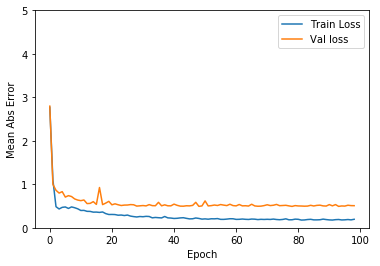

In [11]:
plot_history(history)

In [12]:
result = model.predict(X_test_red, batch_size=32)
rmse(result, y_test)

0.6834309411311952

# Verification of feature selection matrix - polynomial expansion

In [9]:
X_red = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized_red.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")

In [10]:
X_red.shape

(30049, 3004)

In [13]:
X_poly = build_poly(X_red, 2)

In [14]:
X_poly.shape

(30049, 6008)

In [15]:
train_set_size = int(len(X_red) * TRAIN_SET_PERC)
X_poly_train_red = X_poly[: train_set_size]
X_poly_test_red = X_poly[train_set_size:]
y_train = y[: train_set_size]
y_test = y[train_set_size :]

In [16]:
print("X_poly_red: " + str(X_poly.shape))
print("y: " + str(y.shape))

X_poly_red: (30049, 6008)
y: (30049,)


In [18]:
# Clean up as much memory as possible before starting
garbage_collection()

# Prepare model 
model = tf.keras.Sequential([
    # Number of layers and neurons doesn't really matter, we need as much as possible.
    # We well take care of overfitting with regularizers.
    # We chose relu activation (relative usual choice when working on regression)
    # We add L2 regularizers on hidden layers to avoid overfitting the data. Threshold should be tuned.
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    # Last layer represent the electromagnetic shielding, our prediction
    layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])

In [19]:
EPOCHS = 200
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_poly_train_red, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
model.summary()

Train on 24339 samples, validate on 2705 samples
Epoch 1/200
24339/24339 [==============================] - 15s 609us/step - loss: 68.8399 - mean_absolute_error: 5.7557 - val_loss: 27.8898 - val_mean_absolute_error: 3.7220
Epoch 2/200
24339/24339 [==============================] - 12s 498us/step - loss: 6.5372 - mean_absolute_error: 1.8642 - val_loss: 18.6232 - val_mean_absolute_error: 2.6665
Epoch 3/200
24339/24339 [==============================] - 12s 502us/step - loss: 2.9390 - mean_absolute_error: 1.2613 - val_loss: 13.8524 - val_mean_absolute_error: 2.5427
Epoch 4/200
24339/24339 [==============================] - 12s 504us/step - loss: 2.3184 - mean_absolute_error: 1.1061 - val_loss: 16.8185 - val_mean_absolute_error: 2.3774
Epoch 5/200
24339/24339 [==============================] - 12s 508us/step - loss: 2.9168 - mean_absolute_error: 1.1900 - val_loss: 16.8111 - val_mean_absolute_error: 3.0914
Epoch 6/200
24339/24339 [==============================] - 12s 512us/step - loss: 4.4

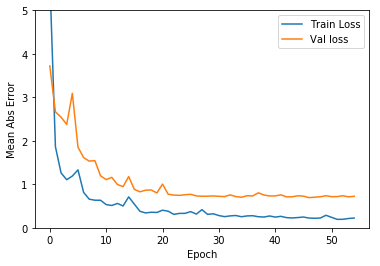

In [20]:
plot_history(history)

In [21]:
result = model.predict(X_poly_test_red, batch_size=32)
rmse(result, y_test)

1.0123385147545783